[source](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('/content/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


Epoch 0: train RMSE 225.7844, test RMSE 425.0235
Epoch 100: train RMSE 177.2231, test RMSE 374.0665
Epoch 200: train RMSE 137.5630, test RMSE 330.5139
Epoch 300: train RMSE 106.9494, test RMSE 293.4974
Epoch 400: train RMSE 85.9395, test RMSE 262.5941
Epoch 500: train RMSE 65.8651, test RMSE 232.4050
Epoch 600: train RMSE 52.1722, test RMSE 205.6987
Epoch 700: train RMSE 42.2407, test RMSE 182.1240
Epoch 800: train RMSE 35.3314, test RMSE 161.6636
Epoch 900: train RMSE 30.6391, test RMSE 143.9282
Epoch 1000: train RMSE 27.7040, test RMSE 128.6514
Epoch 1100: train RMSE 25.1972, test RMSE 116.2459
Epoch 1200: train RMSE 23.4105, test RMSE 106.8877
Epoch 1300: train RMSE 22.6872, test RMSE 99.6938
Epoch 1400: train RMSE 21.5521, test RMSE 92.8323
Epoch 1500: train RMSE 21.0720, test RMSE 87.3620
Epoch 1600: train RMSE 20.3916, test RMSE 85.0141
Epoch 1700: train RMSE 20.6360, test RMSE 82.2093
Epoch 1800: train RMSE 20.3975, test RMSE 79.3389
Epoch 1900: train RMSE 19.5283, test RMSE 76.

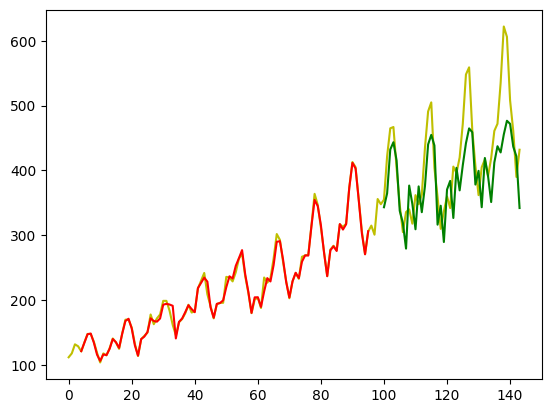

In [6]:
# plot
plt.plot(timeseries, c='y')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

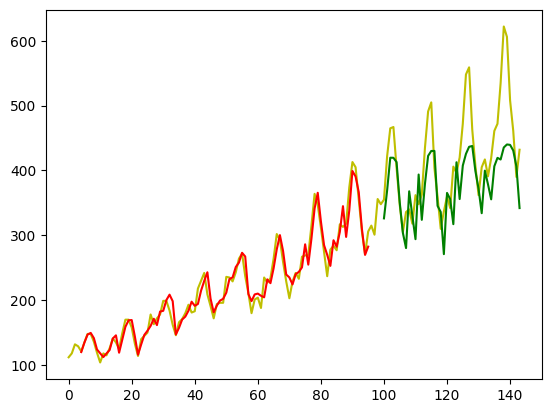

In [4]:
# plot
plt.plot(timeseries, c='y')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()